# Transformer Fine-Tuning (DistilBERT)
This notebook fine-tunes a pre-trained DistilBERT model on the cleaned fake news dataset.  
The goal is to compare transformer-based performance with our baseline Logistic Regression model.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load preprocessed dataset
df = pd.read_csv("../data/processed/cleaned_combined.csv")

# Check basic info
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head(2))

# Split into train/test sets (same ratio as before)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["content"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

print(f"Train samples: {len(train_texts)}, Test samples: {len(test_texts)}")

Dataset shape: (38502, 6)
Columns: ['title', 'text', 'subject', 'date', 'label', 'content']
                                               title  \
0  Ben Stein Calls Out 9th Circuit Court Committe...   
1  Trump drops Steve Bannon from National Securit...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON Reuters U.S. President Donald Trump...  politicsNews   

                date  label                                            content  
0  February 13, 2017      0  Ben Stein Calls Out 9th Circuit Court Committe...  
1     April 5, 2017       1  Trump drops Steve Bannon from National Securit...  
Train samples: 30801, Test samples: 7701


In [4]:
from transformers import DistilBertTokenizerFast

# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Tokenize text data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=256)

print("Example tokenized input:")
print(train_encodings['input_ids'][0][:15])

Example tokenized input:
[101, 24534, 3189, 16420, 10558, 2915, 2158, 2538, 2335, 1010, 3807, 1999, 1996, 2132, 2002]


In [5]:
import torch

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create train/test datasets
train_dataset = NewsDataset(train_encodings, train_labels)
test_dataset = NewsDataset(test_encodings, test_labels)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 30801, Test samples: 7701


In [6]:
from transformers import DistilBertForSequenceClassification

# Load DistilBERT pre-trained for classification
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels=2  # binary classification
)

print("Model loaded successfully.")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully.


## Fine-Tuning Setup & Training
We now fine-tune the pre-trained DistilBERT model on our fake/real news dataset.  
The model already understands general English, so here it learns to classify text specifically as *real* or *fake* news.  
We'll train for a few epochs to adjust the classifier weights.

In [7]:
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Training on: {device}")

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
).to(device)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

trainer.save_model("./trained_distilbert_fake_news")
print("Model saved to './trained_distilbert_fake_news'")

metrics = trainer.evaluate()
print(metrics)


Training on: mps


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,0.000000,0.017146
2,0.000100,0.009046


/opt/homebrew/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Model saved to './trained_distilbert_fake_news'


/opt/homebrew/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.009045553393661976, 'eval_runtime': 129.1003, 'eval_samples_per_second': 59.651, 'eval_steps_per_second': 7.459, 'epoch': 2.0}



📊 DistilBERT Classification Report:

              precision    recall  f1-score   support

        Fake     0.9977    0.9994    0.9986      3462
        Real     0.9995    0.9981    0.9988      4239

    accuracy                         0.9987      7701
   macro avg     0.9986    0.9988    0.9987      7701
weighted avg     0.9987    0.9987    0.9987      7701



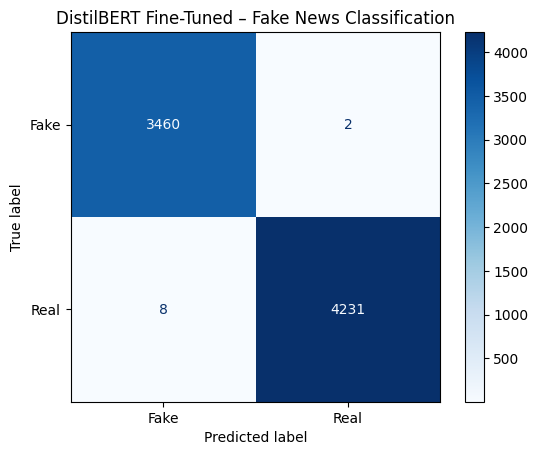


Model Accuracy: 0.9987


In [10]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from transformers import DistilBertForSequenceClassification

# Detect device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load trained model
model_path = "./trained_distilbert_fake_news"
model = DistilBertForSequenceClassification.from_pretrained(model_path)
model.to(device)
trainer.model = model

# Get predictions
predictions = trainer.predict(test_dataset)

# ✅ Extract labels safely (convert to numpy)
if hasattr(test_dataset, "labels"):
    y_true = np.array(test_dataset.labels)
else:
    y_true = np.array(test_dataset["label"])  # HuggingFace DatasetDict format

y_pred = np.argmax(predictions.predictions, axis=1)

# ✅ Classification report
print("\n📊 DistilBERT Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Fake", "Real"], digits=4))

# ✅ Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap="Blues", values_format="d")
plt.title("DistilBERT Fine-Tuned – Fake News Classification")
plt.show()

# ✅ Accuracy summary
accuracy = np.mean(y_true == y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")